In [1]:
import sys; sys.path.append('..')
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision.models.resnet import resnet50
import torchvision.transforms as T
from firelab.base_trainer import BaseTrainer
from firelab.config import Config

from src.dataloaders import cub, awa
from src.dataloaders.load_data import load_data
from src.dataloaders.utils import CustomDataset
from src.utils.losses import LabelSmoothingLoss
from src.models.classifier import resnet_embedder_forward
from src.utils.model_utils import filter_params
from src.utils.constants import INPUT_DIMS


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
cub_ds = cub.load_dataset('../data/CUB_200_2011', split='train', preprocess=False)

[Loading dataset]: 100%|██████████| 5994/5994 [00:37<00:00, 158.29it/s]


In [3]:
awa_ds = awa.load_dataset('../data/Animals_with_Attributes2', split='train')

[Loading dataset]: 100%|██████████| 26102/26102 [08:26<00:00, 51.52it/s]


In [5]:
awa_shapes = [d[0].shape for d in awa_ds]

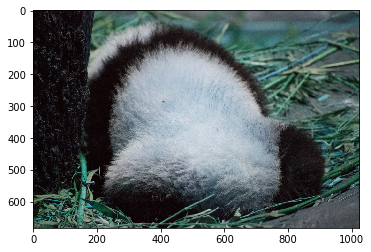

In [40]:
plt.imshow(awa_ds[419][0].astype(np.uint8))

In [73]:
from torchvision import transforms as T
import torchvision.transforms.functional as TVF
from PIL import Image, ImageFile
from src.dataloaders.utils import CustomDataset
from torch.utils.data import DataLoader

# ImageFile.LOAD_TRUNCATED_IMAGES = True

class CenterCropToMin(object):
    """
    CenterCrops an image to a min size
    """
    def __call__(self, img):
        assert TVF._is_pil_image(img)

        return TVF.center_crop(img, min(img.size))

size = 256
img_train_transform = T.Compose([
    T.ToPILImage(),
    #T.RandomResizedCrop(self.config.hp.img_target_shape, scale=(0.2, 1.0)),
    CenterCropToMin(),
    T.RandomHorizontalFlip(),
    T.Resize(size),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

ds = CustomDataset(cub_ds, transform=img_train_transform)
dl = DataLoader(ds, batch_size=10)
b = next(iter(dl))

In [74]:
b[0][0].shape

torch.Size([3, 256, 256])

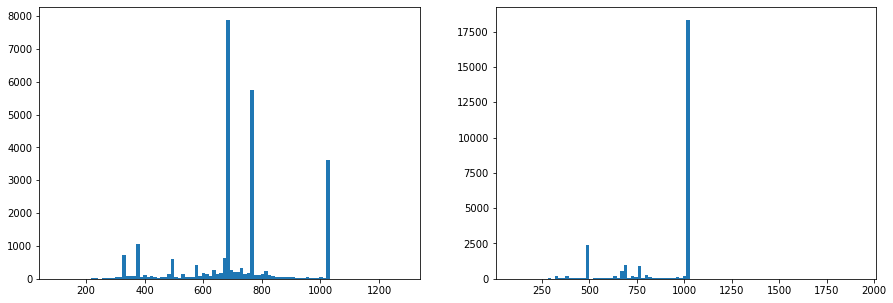

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.hist([s[0] for s in awa_shapes], bins=100);

plt.subplot(122)
plt.hist([s[1] for s in awa_shapes], bins=100);

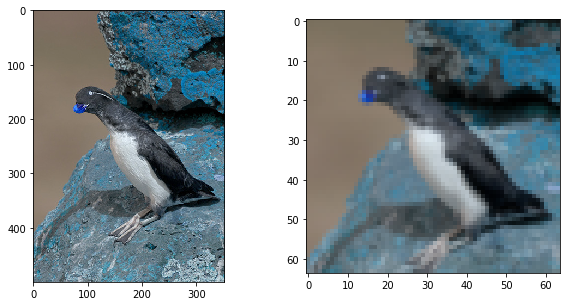

In [78]:
import matplotlib.pyplot as plt
# plt.imshow(cub[1795][0].astype(np.uint8))
i = 1002
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(cub[i][0].astype(np.uint8))
plt.subplot(122)
plt.imshow(img_train_transform(cub[i][0].astype(np.uint8)))

In [136]:
from torchvision import transforms as T
from PIL import Image, ImageFile

# ImageFile.LOAD_TRUNCATED_IMAGES = True

img_train_transform = T.Compose([
    #T.ToPILImage(),
    #T.RandomResizedCrop(200, scale=(0.2, 1.)),
    T.Resize(200),
    T.CenterCrop(200),
    #T.RandomHorizontalFlip(),
    #T.ToTensor(),
    #T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

img = Image.open('tmp2.jpg')

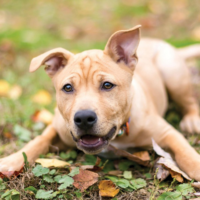

In [137]:
img_train_transform(img)

In [101]:
import sys; sys.path.append('..')
import torch
from torchsummary import summary

DEVICE = 'cuda'

In [2]:
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision.transforms import ToTensor

ds_train = CIFAR100('../data/CIFAR100', train=True, transform=ToTensor())
ds_test = CIFAR100('../data/CIFAR100', train=False, transform=ToTensor())

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# ds_train = Subset(ds_train, range(100))
# ds_test = Subset(ds_test, range(100))

NUM_CLASSES = 100

dl_train = DataLoader(ds_train, batch_size=256, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=256, shuffle=False)

In [6]:
import torch
import torch.nn as nn
from torch import Tensor
from firelab.config import Config

from src.models.layers import ConvBNReLU, ConvTransposeBNReLU, Reshape


class AutoEncoder(nn.Module):
    def __init__(self, config: Config):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder(config)
        self.decoder = Decoder(config)

    def forward(self, x: Tensor) -> Tensor:
        return self.decoder(self.encoder(x))


class Encoder(nn.Module):
    def __init__(self, config: Config):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 4, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 64, 4, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 256, 4, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)
    

class Decoder(nn.Module):
    def __init__(self, config: Config):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)


class ShapePrinter(nn.Module):
    def __init__(self, title: str='unknown'):
        super(ShapePrinter, self).__init__()
        self.title = title

    def forward(self, x):
        print(self.title, x.shape, x.flatten(1).shape)
        return x

In [7]:
# ae = AutoEncoder(None).to('cuda')
# summary(ae, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 31, 31]             784
         MaxPool2d-2           [-1, 16, 15, 15]               0
              ReLU-3           [-1, 16, 15, 15]               0
            Conv2d-4           [-1, 64, 14, 14]          16,448
         MaxPool2d-5             [-1, 64, 7, 7]               0
              ReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 256, 6, 6]         262,400
         MaxPool2d-8            [-1, 256, 3, 3]               0
              ReLU-9            [-1, 256, 3, 3]               0
           Conv2d-10            [-1, 512, 1, 1]       1,180,160
             ReLU-11            [-1, 512, 1, 1]               0
          Encoder-12            [-1, 512, 1, 1]               0
  ConvTranspose2d-13            [-1, 256, 4, 4]       2,097,408
             ReLU-14            [-1, 25

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np

ae = AutoEncoder(None).to(DEVICE)
optim = torch.optim.Adam(ae.parameters())
max_num_epochs = 1000


def validate_ae(model, dataloader):
    all_losses = []
    model.eval()
    
    with torch.no_grad():
        #for x, _ in tqdm(dataloader, desc='Validating', total=len(dataloader)):
        for x, _ in dataloader:
            x = x.to(DEVICE)
            #losses = F.binary_cross_entropy(model(x), x, reduction='none')
            losses = F.mse_loss(model(x), x, reduction='none')
            all_losses.extend(losses.cpu().tolist())
            
    return np.mean(all_losses)


for epoch in tqdm(range(1, max_num_epochs + 1)):
    #for i, (x, _) in tqdm(enumerate(dl_train), desc='Training', total=len(dl_train)):
    for i, (x, _) in enumerate(dl_train):
        ae.train()
        x = x.to(DEVICE)
        
        #loss = F.binary_cross_entropy(ae(x), x)
        loss = F.mse_loss(ae(x), x)
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    if epoch % 100 == 0:
        print(f'[train] Epoch {epoch}. {validate_ae(ae, dl_train)}')
        print(f'[val] Epoch {epoch}: {validate_ae(ae, dl_test)}')

 10%|▉         | 99/1000 [18:09<2:43:14, 10.87s/it]

[train] Epoch 100. 0.0034673046483104956


 10%|█         | 100/1000 [19:02<5:49:38, 23.31s/it]

[val] Epoch 100: 0.0038401547045854305


 11%|█         | 107/1000 [20:18<2:58:36, 12.00s/it]

In [10]:
print(f'[train] Epoch {epoch}. {validate_ae(ae, dl_train)}')
print(f'[val] Epoch {epoch}: {validate_ae(ae, dl_test)}')

[val] Epoch 230: 0.0031530196322596313


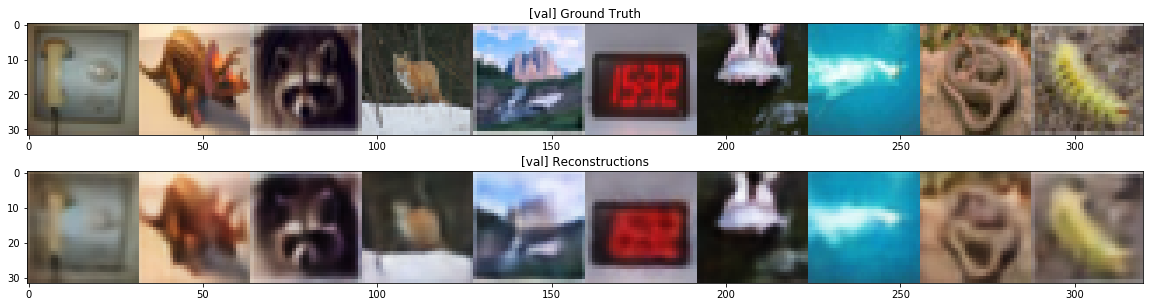

In [15]:
import random
import matplotlib.pyplot as plt

ae.eval()

with torch.no_grad():
    imgs = torch.tensor([ds_test[i][0].tolist() for i in random.sample(range(len(ds_test)), 10)])
    recs = ae(imgs.to(DEVICE)).cpu()

    imgs = imgs.permute(0, 2, 3, 1).numpy()
    recs = recs.permute(0, 2, 3, 1).numpy()


plt.figure(figsize=(20, 5))
plt.subplot(211)
plt.title('[val] Ground Truth')
plt.imshow(np.stack(imgs, axis=1).reshape(32, -1, 3), interpolation='nearest')

plt.subplot(212)
plt.title('[val] Reconstructions')
plt.imshow(np.stack(recs, axis=1).reshape(32, -1, 3), interpolation='nearest')

In [16]:
def extract_features(ae, dataloader):
    ae.eval()
    
    y = []
    feats = []
    
    with torch.no_grad():
        for batch in dataloader:
            feats.extend(ae.encoder(batch[0].to(DEVICE)).cpu().flatten(1).tolist())
            y.extend(batch[1])
            
    return feats, y

feats_train, y_train = extract_features(ae, dl_train)
feats_test, y_test = extract_features(ae, dl_test)

In [17]:
feats_dl_train = DataLoader(list(zip(*[feats_train, y_train])), batch_size=256, shuffle=True, collate_fn=lambda b: list(zip(*b)))
feats_dl_test = DataLoader(list(zip(*[feats_test, y_test])), batch_size=256, shuffle=False, collate_fn=lambda b: list(zip(*b)))

In [18]:
def validate_clf(clf_model, dataloader):
    losses = []
    accs = []

    with torch.no_grad():
        for x, y in dataloader:
            x = torch.tensor(x).to(DEVICE)
            y = torch.tensor(y).to(DEVICE)

            logits = clf_model(x)
            loss = F.cross_entropy(logits, y, reduction='none').cpu().tolist()
            acc = (logits.argmax(dim=1) == y).float().cpu().tolist()
            
            losses.extend(loss)
            accs.extend(acc)
        
    return np.mean(losses), np.mean(accs)

In [19]:
classifier = nn.Sequential(
    #nn.Dropout(0.1),
    #nn.Linear(2048, 256),
    #nn.BatchNorm1d(256),
    #nn.ReLU(),
    #nn.Dropout(0.1),
    #nn.Linear(256, 100)
    nn.Linear(512, 100)
).to(DEVICE)

max_num_epochs = 100
optim = torch.optim.Adam(classifier.parameters(), lr=1e-2)

for epoch in range(max_num_epochs):
    for batch in feats_dl_train:
        x = torch.tensor(batch[0]).to(DEVICE)
        y = torch.tensor(batch[1]).to(DEVICE)

        logits = classifier(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean().detach().cpu()

        optim.zero_grad()
        loss.backward()
        optim.step()

    #print('acc', acc.item())
    if epoch % 5 == 0:
        print('train acc:', validate_clf(classifier, feats_dl_train)[1])
        print('val acc:', validate_clf(classifier, feats_dl_test)[1])

train acc: 0.21558
val acc: 0.194
train acc: 0.28942
val acc: 0.235
train acc: 0.2985
val acc: 0.2396
train acc: 0.30842
val acc: 0.2451
train acc: 0.3173
val acc: 0.2478
train acc: 0.3017
val acc: 0.2329
train acc: 0.3106
val acc: 0.2452
train acc: 0.3276
val acc: 0.252
train acc: 0.32142
val acc: 0.2466
train acc: 0.32092
val acc: 0.2455
train acc: 0.33072
val acc: 0.2525
train acc: 0.32752
val acc: 0.2474
train acc: 0.33382
val acc: 0.2574
train acc: 0.31534
val acc: 0.2363
train acc: 0.32496
val acc: 0.2442
train acc: 0.3328
val acc: 0.2463
train acc: 0.3247
val acc: 0.2427
train acc: 0.34616
val acc: 0.2627
train acc: 0.32606
val acc: 0.245
train acc: 0.3291
val acc: 0.2499
